In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm


In [2]:
def reduce(pos):
    model = PCA(n_components=2)
    W = model.fit_transform(pos)
    H = model.components_
    return W

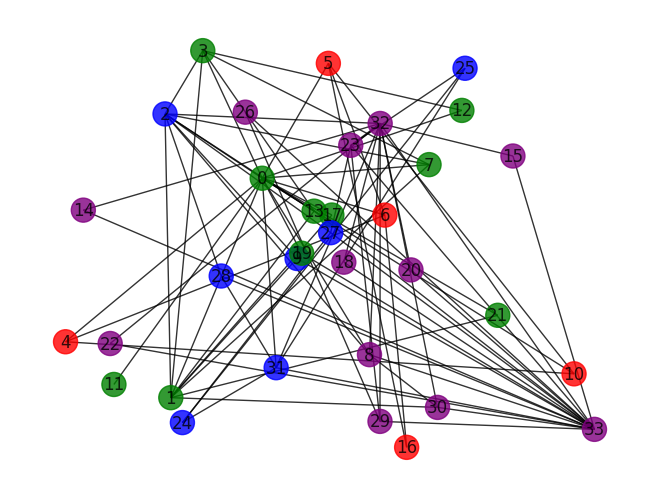

In [3]:
G = nx.karate_club_graph()
np.random.seed(200)

# position
pos = np.random.random((34, 34))
pos2 = reduce(pos)
diction = {}
for i in range(pos2.shape[0]):
    diction[i] = pos2[i]

# the same labeling as the same labeling as https://arxiv.org/abs/1609.02907 and https://arxiv.org/abs/1403.6652
class1 = [4, 6, 5, 10, 16]
class2 = [2, 9, 24, 25, 27, 28, 31]
class3 = [0, 1, 3, 7, 11, 12, 13, 17, 19, 21]
class4 = [8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]

node_color, Label = [], []
for i in range(34):
    if i in class1:
        node_color.append('red'); Label.append(0)
    elif i in class2:
        node_color.append('blue'); Label.append(1)
    elif i in class3:
        node_color.append('green'); Label.append(2)
    else:
        node_color.append('purple'); Label.append(3)
        
nx.draw(G, diction,
        node_color=node_color,
        alpha = 0.8,
        with_labels=True)

In [4]:
# 렉노 참고해서 일반적인 GCN layer, GCN model 클래스 정의
# weight, bias를 xavier init.해야댐
# 따로 학습시키지 말고 레이어 개수에 따라 node embedding이 어떻게 되나 관찰
# 초기 feature는 eye 34, hidden dim은 16, 마지막은 2로 나오게 구성하기
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)

device: mps


In [5]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("num_nodes:", num_nodes)
print("num_edges:", num_edges)

# undirected edges
edge = torch.tensor(list(G.edges()), device=device)

# node features
feat = torch.eye(num_nodes, device=device)

# label
LABEL_ENCODE = {"Mr. Hi": 0, "Officer": 1}
label = torch.tensor([LABEL_ENCODE[info['club']] for _, info in G.nodes.data()])

# degree
degree = torch.tensor([dgr for _, dgr in G.degree()], device=device)

num_nodes: 34
num_edges: 78


In [49]:
class GraphSageLayer(nn.Module):

    def __init__(self, dim_in: int, dim_out: int):
        super(GraphSageLayer, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.act = nn.ReLU()

        self.weight = nn.Parameter(data=torch.zeros((dim_in, dim_out), device=device), requires_grad=False)
        nn.init.xavier_uniform_(self.weight)
        # nn.init.uniform_(self.weight, -1, 1)

    def forward(self, feat: torch.Tensor,
                adjacency: torch.Tensor,
                activate: bool) -> torch.Tensor:
        
        adj_eye = adjacency + torch.eye(num_nodes, device=device)
        degree = torch.sum(adj_eye, dim=1)
        # diag_inv_sqrt = torch.diag(torch.sqrt(1/degree))
        dgr_inv = torch.diag(1/degree)
        
        laplace_sym = dgr_inv @ adj_eye #@ diag_inv_sqrt
        out = laplace_sym @ feat #@ self.weight
        if activate:
            out = self.act(out)
        
        return out

In [37]:
class GraphSage(nn.Module):

    def __init__(self, num_layers: int,
                 dim_in: int,
                 dim_hidden: int,
                 dim_out: int):

        super(GraphSage, self).__init__()

        self.num_layers = num_layers
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out

        self.layers = nn.ModuleList()
        for l in range(num_layers):
            self.layers.append(GraphSageLayer(self.dim_in if l == 0 else self.dim_hidden, self.dim_hidden if l < num_layers-1 else self.dim_out))


    def forward(self, feat: torch.Tensor,
                adj: torch.Tensor) -> torch.Tensor:

        x_in = feat
        for layer in self.layers:
            x_out = layer(x_in, adj, (False if self.layers[-1] == layer else True))
            x_in = x_out

        return x_out
    
    def forward_k_layer(self, feat: torch.Tensor,
                        adj: torch.Tensor,
                        k: int) -> torch.Tensor:
        
        x_in = feat
        for i, layer in enumerate(self.layers):
            if i >= k:
                break
            x_out = layer(x_in, adj, i < k-1)
            x_in = x_out
            
        return x_out


In [8]:
from itertools import combinations

def measure_smoothness(features: torch.Tensor, dim: int) -> torch.float32:
    # dim = 1: feature간 smootheness
    # dim = 0: node간 smoothness
    def compute_sim(i, j, dim):
        if dim == 1:
            return F.cosine_similarity(features[:, i], features[:, j], dim=0)
        elif dim == 0:
            return F.cosine_similarity(features[i, :], features[j, :], dim=0)
        
    n = features.shape[dim]
    combs = combinations(range(n), 2)
    similarities = [torch.abs(compute_sim(i, j, dim)) for i, j in combs]
    return torch.mean(torch.tensor(similarities))



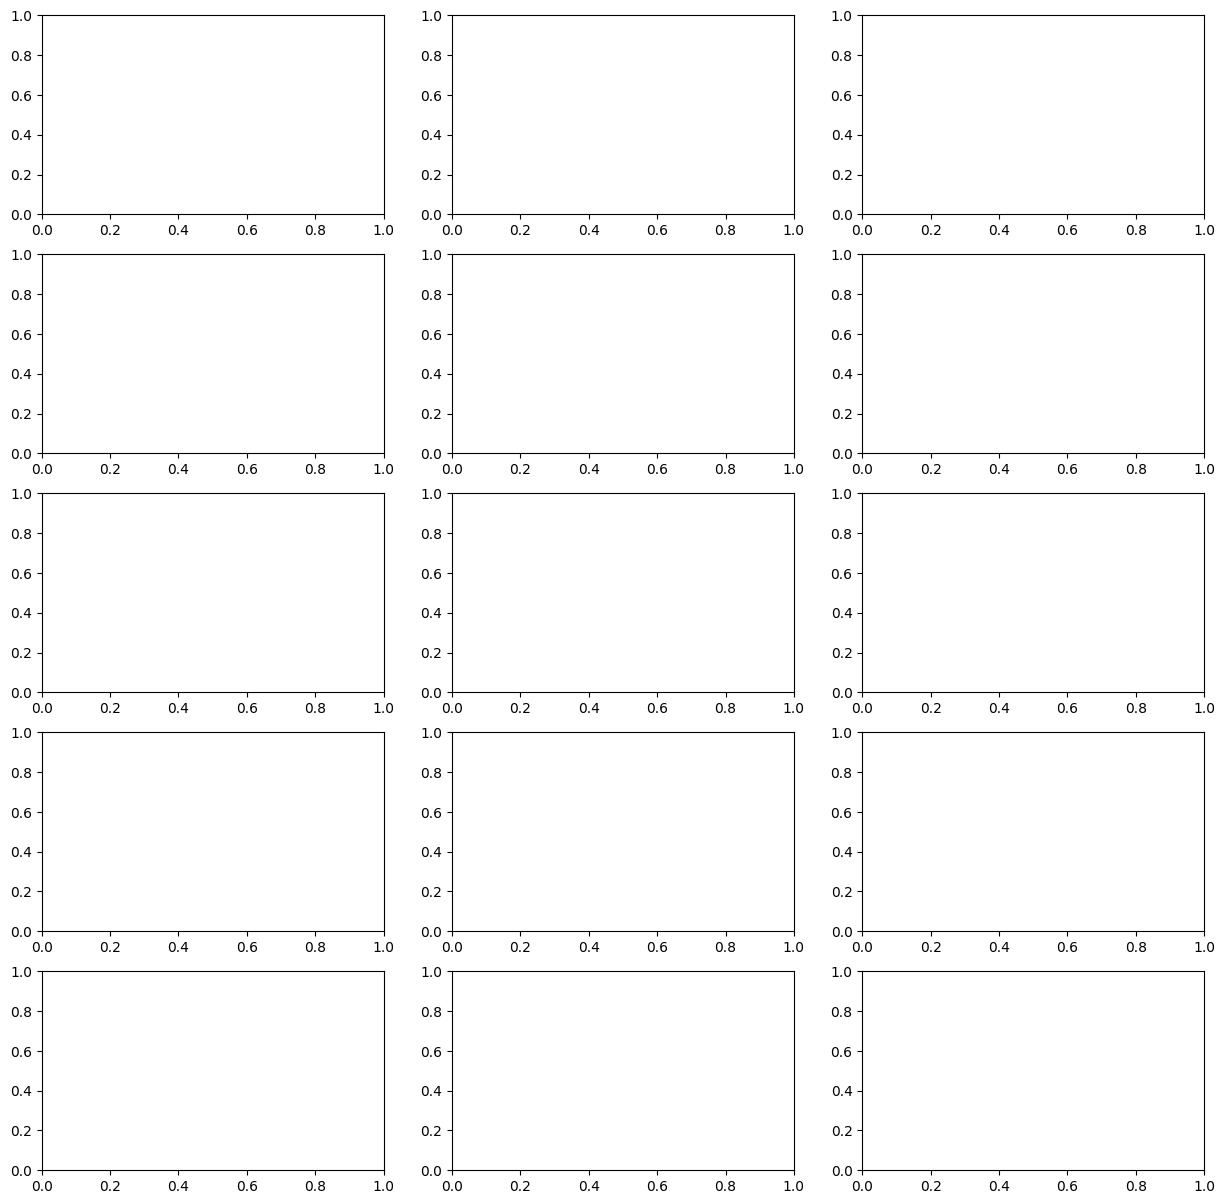

In [12]:
LAYERS = list(range(1, 11))

dim_in = num_nodes
dim_hidden = 16
dim_out = 16
SEED = 42

torch.manual_seed(SEED)

fig, axes = plt.subplots(5, 3, figsize=(15, 15))
palette = sns.color_palette("bright", 2)

feat = torch.eye(num_nodes, device=device)
adj = torch.from_numpy(nx.to_numpy_array(G, weight=None)).type(torch.float32).to(device)

node_smoothness_dict = dict()
feature_smoothness_dict = dict()

for num_layer in LAYERS:
    model = GraphSage(num_layer, dim_in, dim_hidden, dim_out)
    model.eval()

    feature_matrix = model(feat, adj)
    # print(f"node sim avg(k={num_layer}):", measure_smoothness(feature_matrix, 0))
    # print(f"feature sim avg(k={num_layer}):", measure_smoothness(feature_matrix, 1))
    node_smoothness_dict[num_layer] = measure_smoothness(feature_matrix, 0)
    feature_smoothness_dict[num_layer] = measure_smoothness(feature_matrix, 1)
    
    
    # T-SNE fitting for visualization
    # tsne = TSNE(n_components=2)
    # X_embedded = tsne.fit_transform(feature_matrix)
    X_embedded = feature_matrix.cpu().numpy()

    # Draw subplot
    # i, j = divmod(LAYERS.index(num_layer), 3)
    # ax = axes[i, j]
    # ax.set_title(f"Layer {num_layer}")
    # sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=label, legend=False, palette=palette, ax=ax)

# plt.show()


In [33]:
# edge = torch.tensor([[int(i), int(j)] for i, j in edge] + [[int(j), int(i)] for i, j in edge])
# edge = edge.cpu().numpy()
len(edge)

156

In [34]:
# 1. Calculate N_1(v) for lal v \in V. Let neighbor_list_1 = [N_1(v) for v in vertex]
# 2. N_k(v) = \Union_{u \in N_1(v)} N_{k-1}(u)
# 3. For k = 2 to 10, neighbor_list_k = [N_k(v) for v in vertex]
k_hop_neighbor_dict = dict()
for k in range(1, 11):
    k_hop_neighbor_dict[k] = list()

for node in range(num_nodes):
    edge_involve_node = np.where(edge[:, 0] == node)
    k_hop_neighbor_dict[1].append(set(*edge[edge_involve_node, 1].tolist()))

In [35]:
def get_k_neighbor(node: int, k: int) -> set[int]:

    assert k_hop_neighbor_dict[k-1]

    prev_neighbors: set[int] = k_hop_neighbor_dict[k-1][node]
    k_neighbors: set[int] = set()
    for prev in prev_neighbors:
        k_neighbors.update(k_hop_neighbor_dict[1][prev])
    return k_neighbors

def get_k_neighbor_list(k: int) -> None:

    assert k_hop_neighbor_dict[k-1]

    for node in tqdm(range(num_nodes)):
        k_hop_neighbor_dict[k].append(get_k_neighbor(node, k))

for k in range(2, 11):
    get_k_neighbor_list(k)

100%|██████████| 34/34 [00:00<00:00, 132287.88it/s]


In [37]:

k_hop_overlap_dict = dict()
overlap_sim_dict = dict()
for k in tqdm(range(1, 11)):
    k_hop_overlap_dict[k] = np.ones((num_nodes, num_nodes), dtype=np.float32)

    def overlap(i, j) : # NODE i & NODE j
        neighbor_i = k_hop_neighbor_dict[k][i]
        neighbor_j = k_hop_neighbor_dict[k][j]
        Inter_ij = neighbor_i.intersection(neighbor_j)
        len_union_ij = len(neighbor_i) + len(neighbor_j) - len(Inter_ij)
        return len(Inter_ij) / len_union_ij

    overlap_vec = np.vectorize(overlap)

    node_comb = combinations(range(num_nodes), 2)
    i, j = np.array(list(node_comb)).T
    k_hop_overlap_dict[k][i, j] = overlap_vec(i, j)
    avg = np.mean(k_hop_overlap_dict[k][i, j])
    overlap_sim_dict[k] = avg


100%|██████████| 10/10 [00:00<00:00, 949.39it/s]


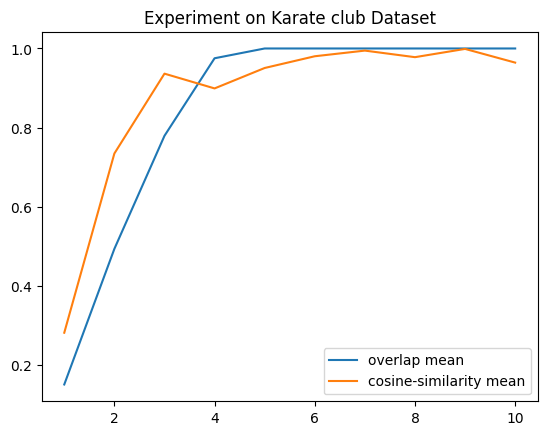

In [41]:
plt.title("Experiment on Karate club Dataset")
plt.plot(LAYERS, overlap_sim_dict.values(), label="overlap mean")
plt.plot(LAYERS, node_smoothness_dict.values(), label="cosine-similarity mean")
plt.legend()
plt.savefig("karate.png")

100%|██████████| 10/10 [00:00<00:00, 129.88it/s]


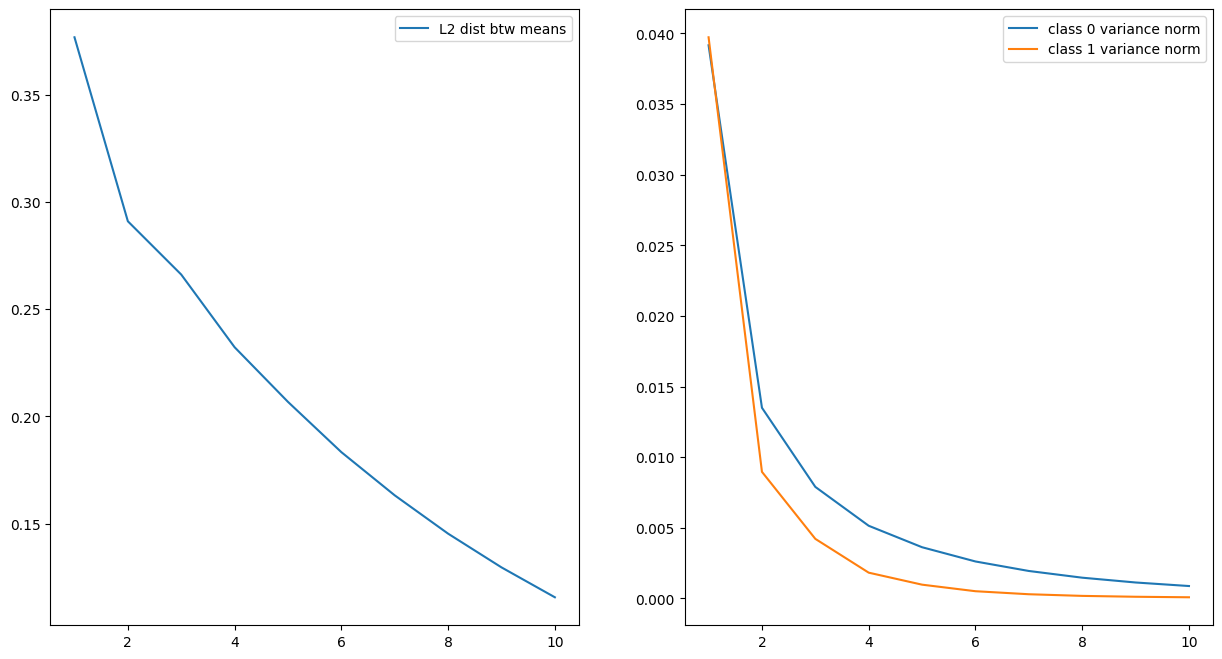

In [78]:
LAYERS = list(range(1, 11))

dim_in = feat.shape[1]
dim_hidden = 16
dim_out = 16
SEED = 43

torch.manual_seed(SEED)

adj = torch.from_numpy(nx.to_numpy_array(G, weight=None)).type(torch.float32).to(device)

model = GraphSage(max(LAYERS), dim_in, dim_hidden, dim_out)
model.eval()

euc_means = []
variance1 = []
variance2 = []

for num_layer in tqdm(LAYERS):

    feature_matrix = model.forward_k_layer(feat, adj, num_layer)
    feature_matrix = feature_matrix
    
    # pca= PCA(n_components=3)
    # embedding = pca.fit_transform(feature_matrix)
    # print("explainable ratio", pca.explained_variance_ratio_)
    embedding = feature_matrix
    
    mean_vec = [torch.mean(embedding[label == l], axis=0) for l in range(0, 2)]
    var_label = [torch.var(embedding[label == l], axis=0) for l in range(0, 2)]
    euc_means.append(F.pairwise_distance(*mean_vec).item())
    variance1.append(torch.norm(var_label[0], p=2).item())
    variance2.append(torch.norm(var_label[1], p=2).item())


fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].plot(LAYERS, euc_means, label="L2 dist btw means")
axes[1].plot(LAYERS, variance1, label="class 0 variance norm")
axes[1].plot(LAYERS, variance2, label="class 1 variance norm")
axes[0].legend()
axes[1].legend()
    